## Import Utils

In [5]:
# @title Parsing JSON output
def parse_json(json_output: str):
    # Parsing out the markdown fencing
    lines = json_output.splitlines()
    for i, line in enumerate(lines):
        if line == "```json":
            json_output = "\n".join(lines[i + 1:])  # Remove everything before "```json"
            json_output = json_output.split("```")[0]  # Remove everything after the closing "```"
            break  # Exit the loop once "```json" is found
    return json_output

In [6]:
import json

from PIL import ImageColor
from PIL import ImageDraw, ImageFont

# @title Plotting Util

additional_colors = [colorname for (colorname, colorcode) in ImageColor.colormap.items()]


def plot_bounding_boxes(im, bounding_boxes):
    """
    Plots bounding boxes on an image with markers for each a name, using PIL, normalized coordinates, and different colors.

    Args:
        im: The path to the image file.
        bounding_boxes: A list of bounding boxes containing the name of the object
         and their positions in normalized [y1 x1 y2 x2] format.
    """

    # Load the image
    img = im
    width, height = img.size
    print(img.size)
    # Create a drawing object
    draw = ImageDraw.Draw(img)

    # Define a list of colors
    colors = [
                 'red',
                 'green',
                 'blue',
                 'yellow',
                 'orange',
                 'pink',
                 'purple',
                 'brown',
                 'gray',
                 'beige',
                 'turquoise',
                 'cyan',
                 'magenta',
                 'lime',
                 'navy',
                 'maroon',
                 'teal',
                 'olive',
                 'coral',
                 'lavender',
                 'violet',
                 'gold',
                 'silver',
             ] + additional_colors

    # Parsing out the markdown fencing
    bounding_boxes = parse_json(bounding_boxes)

    font = ImageFont.truetype("assets/2d_spatial_understanding/NotoSansSC-Regular.ttf", size=14)

    # Iterate over the bounding boxes
    for i, bounding_box in enumerate(json.loads(bounding_boxes)):
        # Select a color from the list
        color = colors[i % len(colors)]

        # Convert normalized coordinates to absolute coordinates
        abs_y1 = int(bounding_box["box_2d"][0] / 1000 * height)
        abs_x1 = int(bounding_box["box_2d"][1] / 1000 * width)
        abs_y2 = int(bounding_box["box_2d"][2] / 1000 * height)
        abs_x2 = int(bounding_box["box_2d"][3] / 1000 * width)

        if abs_x1 > abs_x2:
            abs_x1, abs_x2 = abs_x2, abs_x1

        if abs_y1 > abs_y2:
            abs_y1, abs_y2 = abs_y2, abs_y1

        # Draw the bounding box
        draw.rectangle(
            ((abs_x1, abs_y1), (abs_x2, abs_y2)), outline=color, width=4
        )

        # Draw the text
        if "label" in bounding_box:
            draw.text((abs_x1 + 8, abs_y1 + 6), bounding_box["label"], fill=color, font=font)

    # Display the image
    # img.show()

## Launch

In [7]:
import os

import dotenv
from google import genai
from google.genai import types

dotenv.load_dotenv()

GOOGLE_API_KEY = os.getenv("GEMINI_API_KEY")

client = genai.Client(api_key=GOOGLE_API_KEY)

In [84]:
from PIL import Image
from io import BytesIO
from pathlib import Path

INSTRUCTIONS = """
**Rule for 'Find the Notched Rectangular Area' Tasks:**
1. Identify challenge prompt about the Challenge Image
2. Think about what the challenge requires identification goals, and where are they in the picture
3. Think about what object should be dragged to which position
4. Based on the plane rectangular coordinate system, reasoning about the absolute position of the "answer object" in the coordinate system
"""

PROMPT_L1 = """
Detect the 2d bounding bx of the pipeline(or Lost part of the segments of pipeline).
"""

PROMPT_L2 = """
Detect the 2d bounding box of the missing piece and the answer object. There are only-one missing pieces in the diagram.
missing piece is start, answer object is end.
"""

output_dir = Path("assets/2d_spatial_understanding")

image = output_dir.joinpath("20250420105736697865_0_challenge_view.png")

# Load and resize image
im_raw = Image.open(BytesIO(open(image, "rb").read()))
im_raw.thumbnail([1024, 1024], Image.Resampling.LANCZOS)

MODEL_ID = "gemini-2.5-pro-preview-03-25"

response_layer_1 = client.models.generate_content(
    model=MODEL_ID,
    contents=[PROMPT_L1, im_raw],
    config=types.GenerateContentConfig(
        temperature=0,
        response_mime_type="application/json",
    )
)

im_layer_1 = im_raw.copy()
plot_bounding_boxes(im_layer_1, response_layer_1.text)

response_layer_2 = client.models.generate_content(
    model=MODEL_ID,
    contents=[PROMPT_L2, im_layer_1],
    config=types.GenerateContentConfig(
        temperature=0,
        response_mime_type="application/json",
        system_instruction=INSTRUCTIONS
    )
)

im_layer_2 = im_layer_1.copy()
plot_bounding_boxes(im_layer_2, response_layer_2.text)

(501, 431)
(501, 431)


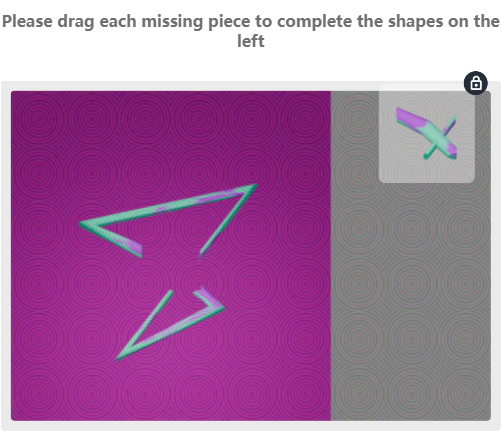

In [80]:
im_raw

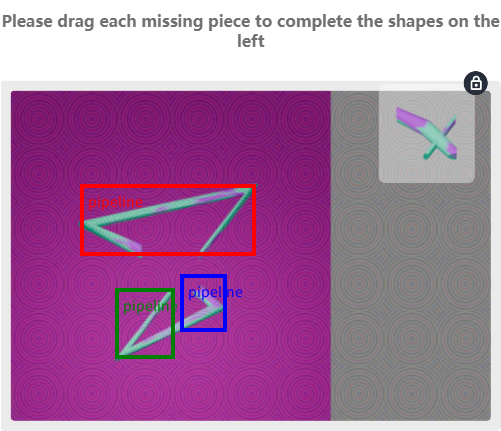

In [86]:
im_layer_1

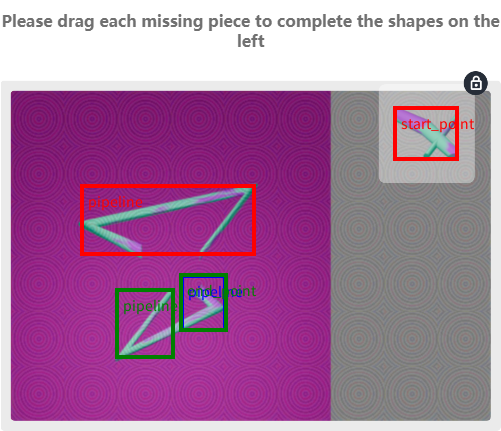

In [85]:
im_layer_2